In [1]:
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob
from keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
from keras.layers import Flatten, LSTM, Dropout, Bidirectional, Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, concatenate, Conv2DTranspose, BatchNormalization, Activation, ConvLSTM2D
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pickle

import matplotlib.pyplot as plt
from matplotlib.path import Path
import cv2

from keras.preprocessing.image import img_to_array, array_to_img


In [2]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [3]:
volume_tracings = pd.read_csv('VolumeTracings.csv')
file_list = pd.read_csv('FileList.csv')
# only takes in the files where frame height and frame width are 112
adjusted_file_list = file_list[(file_list['FrameHeight'] == 112) & (file_list['FrameWidth'] == 112)]
volume_tracings

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46
...,...,...,...,...,...,...
425005,0XFEBEEFF93F6FEB9.avi,45.419984,55.131136,69.758942,57.498739,38
425006,0XFEBEEFF93F6FEB9.avi,45.017994,57.543075,69.399107,59.914779,38
425007,0XFEBEEFF93F6FEB9.avi,44.616005,59.955014,69.039271,62.330818,38
425008,0XFEBEEFF93F6FEB9.avi,44.214015,62.366952,68.712853,64.750108,38


In [4]:
adjusted_file_list

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL
...,...,...,...,...,...,...,...,...,...
10019,0XFDFBA5702E94ABF,53.648451,40.224359,86.781046,112,112,62,192,TRAIN
10020,0XFDFD17B7CCFE5AF,63.338180,28.333805,77.284229,112,112,50,268,TRAIN
10021,0XFE6E32991136338,32.783248,113.063526,168.207364,112,112,43,120,TEST
10022,0XFE83FF3D3B13C3A,64.084988,13.714901,38.187097,112,112,50,192,VAL


In [5]:
adjusted_file_list['Split'].unique()

array(['VAL', 'TRAIN', 'TEST'], dtype=object)

In [6]:
train_file_list = adjusted_file_list[adjusted_file_list['Split'] == 'TRAIN']
val_file_list = adjusted_file_list[adjusted_file_list['Split'] == 'VAL']
test_file_list = adjusted_file_list[adjusted_file_list['Split'] == 'TEST']

In [7]:
def get_frame_from_video(frame_number, filename):
    cap = cv2.VideoCapture('Videos/' + filename)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
    res, image = cap.read()
    return image

In [8]:


def get_frames_and_masks(filenames):
    masks = []
    images = []
    # for file in filenames[0:10]:
    for file in filenames:
        file_tracings = volume_tracings[volume_tracings['FileName'] == file]
        frames_in_file = file_tracings.Frame.unique()
        for frame in frames_in_file:
            tracings = file_tracings[file_tracings['Frame'] == frame]
            tracings.index = np.arange(0, len(tracings))
            # get the coordinates of the tracing
            coordinates = []
            for row_num in range(len(tracings)):
                x1 = tracings['X1'][row_num]
                y1 = tracings['Y1'][row_num]
                x2 = tracings['X2'][row_num]
                y2 = tracings['Y2'][row_num]

                
                if row_num == 0:
                    # for the first row, we want the higher y to be the first coordinate
                    if y2-y1 > 0:
                        coordinates.append([x2, y2])
                        coordinates.append([x1, y1])
                    else:
                        coordinates.append([x1, y1])
                        coordinates.append([x2, y2])
                else:
                    coordinates.insert(1,[x1,y1])
                    coordinates.append([x2,y2])
            width = 112
            height = 112
            x, y = np.meshgrid(np.arange(width), np.arange(height)) # make a canvas with coordinates
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x,y)).T 

            p = Path(coordinates) # make a polygon
            grid = p.contains_points(points)
            mask = grid.reshape(height,width) # now you have a mask with points inside a polygon
            masks.append(mask)
            

            # takes the frame and filename as input, outputs an array of the pixel values of the video at that frame
            image = get_frame_from_video(frame, file)
            images.append(image)
            
    return images, masks

In [9]:
train_filenames = train_file_list.FileName.unique() + '.avi'
val_filenames = val_file_list.FileName.unique() + '.avi'
test_filenames = test_file_list.FileName.unique() + '.avi'
train_frames, train_masks = get_frames_and_masks(train_filenames)
val_frames, val_masks = get_frames_and_masks(val_filenames)
test_frames, test_masks = get_frames_and_masks(test_filenames)

In [10]:
np.average(train_masks[0]*1)

0.09207589285714286

In [11]:
np.average(train_masks*1)

0.09216614888247525

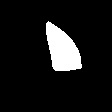

In [12]:
train_mask_resized = np.expand_dims(train_masks, axis=3)
array_to_img(train_mask_resized[0]*255)

In [13]:
np.shape(train_mask_resized)

(14920, 112, 112, 1)

In [14]:
np.shape(train_frames)

(14920, 112, 112, 3)

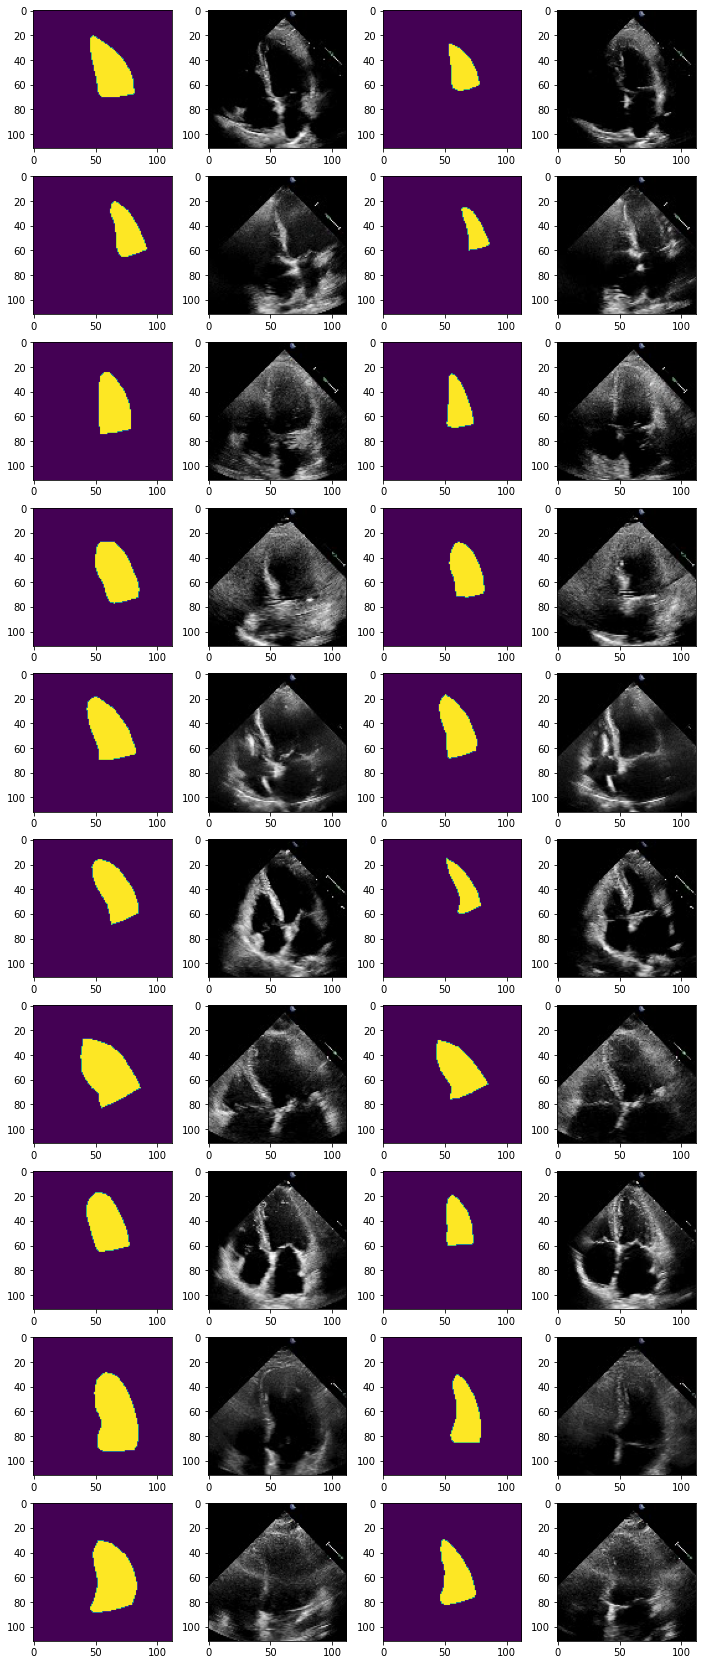

In [15]:
import matplotlib.pyplot as plt
num_samples = 10
f, axarr = plt.subplots(num_samples,4,figsize=(12,num_samples*3))
for i in range(num_samples):
    axarr[i, 0].imshow(train_mask_resized[2*i]*255)
    axarr[i, 1].imshow(train_frames[2*i])
    axarr[i, 2].imshow(train_mask_resized[2*i+1]*255)
    axarr[i, 3].imshow(train_frames[2*i+1])

In [16]:
with open('train.npy', 'wb') as f:
    np.save(f, train_frames)
    np.save(f, train_masks)
with open('val.npy', 'wb') as f:
    np.save(f, val_frames)
    np.save(f, val_masks)
with open('test.npy', 'wb') as f:
    np.save(f, test_frames)
    np.save(f, test_masks)